# 5장 머신러닝의 핵심 이슈

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 3장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**tensorflow 버전과 GPU 확인**
- 구글 코랩 설정: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU 지정 후 아래 명령어 실행 결과 확인

    ```
    !nvidia-smi
    ```

- 사용되는 tensorflow 버전 확인

    ```python
    import tensorflow as tf
    tf.__version__
    ```
- tensorflow가 GPU를 사용하는지 여부 확인

    ```python
    tf.config.list_physical_devices('GPU')
    ```

## 주요 내용

- 머신러닝의 핵심 이슈 이해: 모델 일반화와 모델 훈련 최적화 사이의 관계 조율
- 머신러닝 모델 평가 기법
- 모델 훈련 최적화 기법
- 모델 일반화 성능 향상 기법

## 5.1 머신러닝의 목표: 모델 일반화

훈련을 많이 할 수록 모델은 훈련 세트에 대해 보다 좋은 성능을 보이지만 새로운 데이터에 대한 
성능은 점점 떨어지는 과대적합 현상이 언제나 발생한다. 
머신러닝의 핵심 이슈는 모델 훈련의 **최적화**(optimization)와 
모델 **일반화**(generalization) 사이의 관계를 적절히 조절하는 것이다.

- **최적화**: 훈련 세트에 대해 가장 좋은 성능을 이끌어 내는 과정
- **일반화**: 처음 보는 데이터를 처리하는 모델의 능력

### 과소적합과 과대적합

- 과소적합
    - 훈련 초반
    - 훈련셋과 검증셋 모두에 대해 성능이 향상되는 과정
    - 신경망이 훈련셋의 패턴을 아직 덜 파악한 상태

- 과대적합
    - 훈련셋 고유의 패턴을 학습하기 시작
    - 새로운 데이터와 무관하거나 혼동을 주는 패턴 학습

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/typical_overfitting.png" style="width:700px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

#### 일반화 성능이 좋은 모델 대 과대적합 모델

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/outliers_and_overfitting.png" style="width:660px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

#### 과대적합 발생 주요 요인

과대적합을 발생시키는 요소는 크게 세 가지로 나뉜다.

##### 첫째, 소음(noise) 섞인 훈련셋.

- 적절하지 않은 데이터 또는 잘못된 레이블을 갖는 데이터 등을 **소음** 또는 **노이즈**(noise)라 부름.
- 적절하지 않은 데이터: 다음 MNNIST 이미지들처럼 불분명하면 특성 파악 어려움.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/fucked_up_mnist.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

- 잘못된 레이블: 예를 들어, 잘못 분류된 1처럼 생긴 이미지를 7로 잘못 분류할 가능성이 높아짐.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/mislabeled_mnist.png" style="width:660px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

##### 둘째, 애매한 특성.

- 소음이 전혀 없는 데이터라 하더라도 특정 특성 영역이 여러 레이블과 연관될 수 있음.

- 예제: 붓꽃 데이터의 꽃잎 길이와 너비를 활용한 
    버시컬러(versicolor) 품종과 버지니카(virginica) 품종의 완벽한 구분 불가능.

<div align="center"><img src="https://codingalzi.github.io/handson-ml2/slides/images/ch05/homl05-03b.png" style="width:500px;"></div>

- 아래 오른쪽 그림이 과대적합 모델 표현

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/overfitting_with_uncertainty.png" style="width:660px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

##### 셋째: 매우 드문 특성 또는 거짓 상관관계

- 매우 드문 특성
    - 예제: IMDB 데이터셋에서 매우 낮은 빈도로 사용되는 단어를 훈련셋에서 포함시키는 경우
        어쩌다 한 번 사용되는 특성으로 인해 잘못된 판단이 유도될 수 있음.

- 거짓된 상관관계를 유발하는 훈련셋
- 예제: MNIST 데이터셋에 **백색 소음**(white noise)이 포함된 데이터셋과 그렇지 않은 데이터셋 비교 참조.

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

# MNIST 데이터셋 적재 및 전처리
(train_images, train_labels), _ = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

# 백색 소음 추가
train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)

# 크기를 맞추기 위해 영 행렬 추가
train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

In [2]:
train_images_with_noise_channels.shape

(60000, 1568)

In [3]:
train_images_with_zeros_channels.shape

(60000, 1568)

백색 소음이 들어간 샘플은 다음과 같이 보인다.

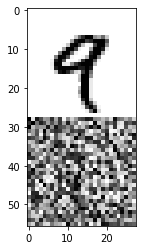

In [4]:
train_image_white4 = train_images_with_noise_channels[4].reshape((56, 28))

import matplotlib.pyplot as plt

digit = train_image_white4
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

영 행렬이 추가된 샘플은 다음과 같이 보인다.

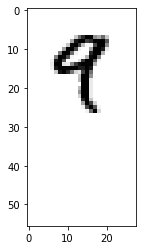

In [5]:
train_image_zeros4 = train_images_with_zeros_channels[4].reshape((56, 28))

import matplotlib.pyplot as plt

digit = train_image_zeros4
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

모델 구성과 컴파일을 함수를 이용하여 지정한다.

- 정수 레이블을 사용하기에 손실함수로 `sparse_categorical_crossentropy` 지정해야 함.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

- 백색 소음이 추가된 데이터셋 훈련
    - `validation_split`: 검증셋 비율 지정

In [7]:
# 모델 생성 및 훈련
model = get_model()

history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 4ms/step - loss: 0.6229 - accuracy: 0.8107 - val_loss: 0.3443 - val_accuracy: 0.8842
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.2516 - accuracy: 0.9220 - val_loss: 0.1802 - val_accuracy: 0.9470
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.9486 - val_loss: 0.1660 - val_accuracy: 0.9508
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1155 - accuracy: 0.9636 - val_loss: 0.1496 - val_accuracy: 0.9565
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0852 - accuracy: 0.9729 - val_loss: 0.1524 - val_accuracy: 0.9563
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0634 - accuracy: 0.9798 - val_loss: 0.1099 - val_accuracy: 0.9685
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0474 - accuracy: 0.9851 - val_loss: 0.1641 - val_accuracy: 0.9569
Epoch 

- 영 행렬이 추가된 데이터셋 훈련
    - `validation_split`: 검증셋 비율 지정

In [8]:
model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 4ms/step - loss: 0.2853 - accuracy: 0.9173 - val_loss: 0.1451 - val_accuracy: 0.9594
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1196 - accuracy: 0.9643 - val_loss: 0.1038 - val_accuracy: 0.9703
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0789 - accuracy: 0.9762 - val_loss: 0.0843 - val_accuracy: 0.9755
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0571 - accuracy: 0.9831 - val_loss: 0.0828 - val_accuracy: 0.9754
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0424 - accuracy: 0.9873 - val_loss: 0.0838 - val_accuracy: 0.9762
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0322 - accuracy: 0.9906 - val_loss: 0.0862 - val_accuracy: 0.9772
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0249 - accuracy: 0.9929 - val_loss: 0.0789 - val_accuracy: 0.9801
Epoch 

- 정확도 비교: 백색 소음이 포함된 훈련셋을 이용한 모델의 정확도 성능이 1% 이상 낮음.

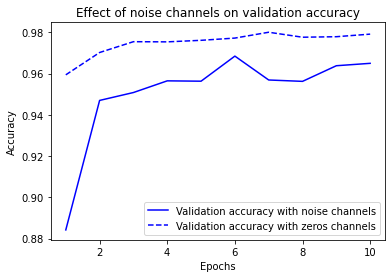

In [9]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]

epochs = range(1, 11)

plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")

plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")

plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

**특성 선택**

- 과대적합 문제를 위해 훈련에 유용한 특성을 선택해야함.
    - IMDB 예제: 빈도수 10,000 등 이내의 단어만 사용
    - 백색 소음 예제: 백색 소음 부분 제거
- 하지만 유용한 특성을 선택하는 일이 기본적으로 불가능하거나 매우 어려움.

### 딥러닝 모델의 일반화

아래 예제에서 확인할 수 있듯이 딥러닝 모델은 어떤 무엇도 학습할 수 있다.

**MNIST 모델을 임의로 섞은 레이블과 함께 훈련시키기**

- 임의로 섞인 레이블을 이용한 모델 훈련

In [10]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_images, random_train_labels,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3166 - accuracy: 0.1050 - val_loss: 2.3088 - val_accuracy: 0.0984
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3012 - accuracy: 0.1157 - val_loss: 2.3132 - val_accuracy: 0.1019
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2908 - accuracy: 0.1276 - val_loss: 2.3221 - val_accuracy: 0.1005
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2771 - accuracy: 0.1398 - val_loss: 2.3333 - val_accuracy: 0.1028
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2601 - accuracy: 0.1538 - val_loss: 2.3425 - val_accuracy: 0.1009
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2396 - accuracy: 0.1700 - val_loss: 2.3541 - val_accuracy: 0.0972
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 2.2143 - accuracy: 0.1839 - val_loss: 2.3716 - val_accuracy: 0.1018

Epoch 58/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9763 - accuracy: 0.6752 - val_loss: 4.5894 - val_accuracy: 0.1028
Epoch 59/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9591 - accuracy: 0.6819 - val_loss: 4.6010 - val_accuracy: 0.1039
Epoch 60/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9472 - accuracy: 0.6839 - val_loss: 4.6776 - val_accuracy: 0.1028
Epoch 61/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9330 - accuracy: 0.6888 - val_loss: 4.7252 - val_accuracy: 0.1029
Epoch 62/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9200 - accuracy: 0.6938 - val_loss: 4.7915 - val_accuracy: 0.1021
Epoch 63/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9045 - accuracy: 0.7007 - val_loss: 4.8487 - val_accuracy: 0.1032
Epoch 64/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8945 - accuracy: 0.7025 - val_loss: 4.9064 - val_accuracy:

훈련셋에 대한 성능은 훈련하면서 계속 향상되지만 검증셋에 성능은 전혀 향상되지 않는다.

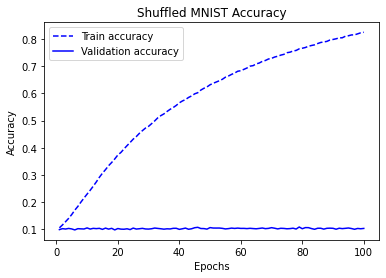

In [12]:
import matplotlib.pyplot as plt

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, 101)

plt.plot(epochs, train_acc, "b--",
         label="Train accuracy")

plt.plot(epochs, val_acc, "b-",
         label="Validation accuracy")

plt.title("Shuffled MNIST Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

**일반화**가 모델 보다는 사용되는 **데이터셋 내부에 존재하는 정보 구조**와 
보다 밀접히 관련된다고 결론징을 수 있다. 
더 나아가 잘 훈련된 모델이 새로운 데이터에 대한 예측을 잘 하는 근거로 
**다양체 가설**이 거론된다.

#### 다양체 가설

일반적인 데이터셋은 고차원상에 존재하는 (저차원의) 연속이며 미분가능한 다양체를 구성한다는 가설이
**다양체 가설**(manifold hypothesis)이다.
그리고 모델 훈련은 바로 이 다양체를 찾아가는 과정이다. 
이런 의미에서 무작위로 섞은 레이블을 사용하는 위 MNIST 예제는 일반적인 데이터셋이 될 수 없다. 
아래 두 개의 이미지는 3차원 공간에 존재하는 두 개의 2차원 다양체를 보여준다.

<table>
    <tr>
        <td> <img src="https://codingalzi.github.io/handson-ml2/slides/images/ch08/homl08-02.png" width="400"/> </td>
        <td></td>
        <td> <img src="https://codingalzi.github.io/handson-ml2/slides/images/ch08/homl08-04.png" width="300"/> </td>
    </tr>
</table>

그림 출처: [핸즈온 머신러닝(2판)](https://github.com/ageron/handson-ml2)

다양체 가설을 이용하면 적절하게 구성된 모델이 적절한 훈련셋으로 훈련받았을 때 새로운 데이터에 대해 적절한 예측을 할 수 있는 이유를 설명할 수 있다.
즉, 모델이 찾은 연속이며 미분가능한 다양체와 학습된 데이터 정보에 **보간법**을 적용하여 새로운 데이터에 대해 예측을 실행한다.

#### 보간법

**보간법**(interpolation)은 훈련셋의 데이터와 새로운 데이터를 연결하는 다양체 상의 경로를 이용하여 예측값을 실행하는 것을 의미한다. 
보다 큰 훈련셋을 사용할 수록 보간법이 보다 잘 작동하지만 
**차원의 저주**(curse of dimensions)에 의해 충분한 크기의 훈련셋 구하기가 
일반적으로 불가능하거나 매우 어렵다. 
    
**참고**: 사람은 보간법 이외의 다른 능력을 사용하여 사물 예측과 구분, 주변 파악, 상황 판단 등 
일반화에 필요한 일을 실행한다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/dense_sampling.png" style="width:660px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

#### 충분치 않은 훈련셋과 정규화

훈련셋을 충분히 크게 만들지 못하는 경우 과대한 추측을 통해 과대적합이 발생할 가능성이 높으며,
이를 방지하기 위해 두 가지 접근법이 있다.

- 모델에 저장되는 정보를 적절하게 조정하기
- 모델이 생성하는 다양체의 곡률 완화

위 두 방법을 통해 모델이 보다 중요한 데이터의 패턴에 집중하도록 만들게 된다.
이런식으로 과대적합을 방지하는 기법을 **정규화**(regularization)이라 부른다.

## 5.2 모델 평가

- 모델의 일반화 능력을 평가하는 다양한 방식 소개

### Training, validation, and test sets

#### Simple hold-out validation

#### K-fold validation

#### Iterated K-fold validation with shuffling

### Beating a common-sense baseline

### Things to keep in mind about model evaluation

## Improving model fit

### Tuning key gradient descent parameters

**Training a MNIST model with an incorrectly high learning rate**

In [0]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1.),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

**The same model with a more appropriate learning rate**

In [0]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

### Leveraging better architecture priors

### Increasing model capacity

**A simple logistic regression on MNIST**

In [0]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_small_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

In [0]:
import matplotlib.pyplot as plt
val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [0]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

## Improving generalization

### Dataset curation

### Feature engineering

### Using early stopping

### Regularizing your model

#### Reducing the network's size

**Original model**

In [0]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

**Version of the model with lower capacity**

In [0]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

**Version of the model with higher capacity**

In [0]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

#### Adding weight regularization

**Adding L2 weight regularization to the model**

In [0]:
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

**Different weight regularizers available in Keras**

In [0]:
from keras import regularizers
regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)

#### Adding dropout

**Adding dropout to the IMDB model**

In [0]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

## Chapter summary